In [1]:
# Cell 1 - imports & load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
import statsmodels.api as sm
import shap

# load
path = "C:/Users/UserAdmin/Desktop/5126final/model/preprocessed_data.csv"   # adjust if needed
df = pd.read_csv(path)
print("rows, cols:", df.shape)
# quick peek
df[[c for c in df.columns if c.startswith('Q274')][:1]].head()


rows, cols: (2012, 287)


,Q274: How many children do you have
0,1.0
1,0.0
2,0.0
3,1.0
4,3.0


In [2]:
# Cell 2 - create age and target, filter
CURRENT_YEAR = 2025
# target column (as found)
target_col = 'Q274: How many children do you have'
birth_year_col = 'Q261: Year of birth'  # exists in dataset preview
country_col = 'Q266: Country of birth: Respondent'  # numeric ISO code

# convert to numeric and handle bad/missing
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
df[birth_year_col] = pd.to_numeric(df[birth_year_col], errors='coerce')
df[country_col] = pd.to_numeric(df[country_col], errors='coerce')

# compute age
df['age'] = CURRENT_YEAR - df[birth_year_col]

# childbearing filter: 20-49 (common bracket) — adjust if needed
df_childbearing = df[(df['age'] >= 20) & (df['age'] <= 49)].copy()
print("childbearing rows:", df_childbearing.shape[0])

# Singapore subset (ISO numeric 702)
df_sg = df_childbearing[df_childbearing[country_col] == 702].copy()
print("Singapore rows (20-49):", df_sg.shape[0])

# global (all countries in same age bracket)
df_global = df_childbearing.copy()


childbearing rows: 875
Singapore rows (20-49): 699


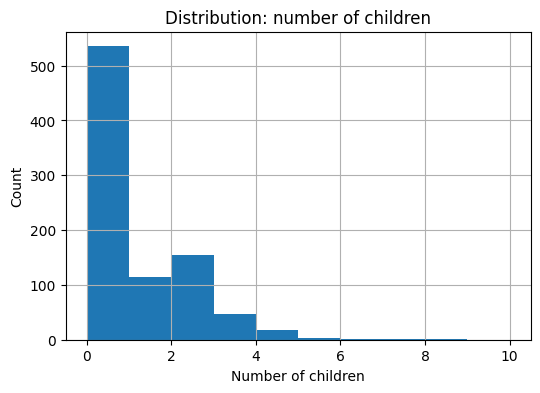

N_REGION_ISO: Region ISO 3166-2                                           0.0
Q1: Important in life: Family                                             0.0
Q2: Important in life: Friends                                            0.0
Q3: Important in life: Leisure time                                       0.0
Q4: Important in life: Politics                                           0.0
Q5: Important in life: Work                                               0.0
Q6: Important in life: Religion                                           0.0
Q7: Important child qualities: good manners                               0.0
Q8: Important child qualities: independence                               0.0
Q9: Important child qualities: hard work                                  0.0
Q10: Important child qualities: feeling of responsibility                 0.0
Q11: Important child qualities: imagination                               0.0
Q12: Important child qualities: tolerance and respect for other 

In [3]:
# Cell 3 - EDA: target distribution and missingness
import matplotlib.pyplot as plt

# target distribution
plt.figure(figsize=(6,4))
df_childbearing[target_col].dropna().hist(bins=range(0,11))
plt.title('Distribution: number of children')
plt.xlabel('Number of children')
plt.ylabel('Count')
plt.show()

# missingness overview for top columns
miss = df_childbearing.isnull().mean().sort_values()
miss.head(30)


In [4]:
# Example: auto-select some candidate features by keyword rules (adjust manually for best features)
value_keywords = ['Important', 'Duty', 'Worries', 'Satisfaction', 'Problem', 'attitude', 'value', 'worries', 'scale']
candidate_cols = [c for c in df.columns if any(k.lower() in c.lower() for k in ['important', 'duty', 'worries', 'satisfaction', 'problem', 'scale', 'chief wage', 'income', 'spend', 'household'])]
# ensure target + controls present
controls = ['age', 'Q270: Number of people in household']
candidate_cols = list(dict.fromkeys(candidate_cols + controls))
len(candidate_cols), candidate_cols[:40]


(44,
 ['Q1: Important in life: Family',
  'Q2: Important in life: Friends',
  'Q3: Important in life: Leisure time',
  'Q4: Important in life: Politics',
  'Q5: Important in life: Work',
  'Q6: Important in life: Religion',
  'Q7: Important child qualities: good manners',
  'Q8: Important child qualities: independence',
  'Q9: Important child qualities: hard work',
  'Q10: Important child qualities: feeling of responsibility',
  'Q11: Important child qualities: imagination',
  'Q12: Important child qualities: tolerance and respect for other people',
  'Q13: Important child qualities: thrift saving money and things',
  'Q14: Important child qualities: determination perseverance',
  'Q15: Important child qualities: religious faith',
  'Q16: Important child qualities: unselfishness',
  'Q17: Important child qualities: obedience',
  'Q30: University is more important for a boy than for a girl',
  'Q35: Problem if women have more income than husband',
  'Q37: Duty towards society to have ch

In [5]:
# Cell 5A - Poisson using statsmodels (requires adding constant)
# Ensure required variables exist (features, X_sg_proc, y_sg). Fall back to sensible defaults.

# use candidate_cols (from earlier cell) if 'features' is not defined
if 'features' not in globals():
	features = candidate_cols  # candidate_cols defined in Cell 3

# Prepare X and y from the Singapore subset df_sg
X_sg = df_sg[features].copy()
y_sg = df_sg[target_col].copy()

# keep only rows with observed target
mask = y_sg.notna()
X_sg = X_sg.loc[mask]
y_sg = y_sg.loc[mask]

# simple preprocessing: impute numeric missings with column medians
X_sg_proc = X_sg.fillna(X_sg.median())

# add constant and fit Poisson GLM
X_sm = sm.add_constant(X_sg_proc)
poisson_model = sm.GLM(y_sg.values, X_sm, family=sm.families.Poisson()).fit()
print(poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  699
Model:                            GLM   Df Residuals:                      654
Model Family:                 Poisson   Df Model:                           44
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -568.56
Date:                Mon, 03 Nov 2025   Deviance:                       552.85
Time:                        23:35:02   Pearson chi2:                     610.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5893
Covariance Type:            nonrobust                                         
                                                                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

In [6]:
nb_model = sm.GLM(y_sg.values, X_sm, family=sm.families.NegativeBinomial()).fit()
print(nb_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  699
Model:                            GLM   Df Residuals:                      654
Model Family:        NegativeBinomial   Df Model:                           44
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -597.59
Date:                Mon, 03 Nov 2025   Deviance:                       342.90
Time:                        23:35:02   Pearson chi2:                     407.
No. Iterations:                    11   Pseudo R-squ. (CS):             0.4256
Covariance Type:            nonrobust                                         
                                                                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

c:\Users\UserAdmin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [7]:
# Cell 5B - RF regressor with cross-validation
rf = RandomForestRegressor(n_estimators=200, random_state=42)
scores = cross_val_score(rf, X_sg_proc, y_sg, cv=5, scoring='neg_mean_squared_error')
print("CV RMSE:", np.sqrt(-scores).mean())
# train final
rf.fit(X_sg_proc, y_sg)


CV RMSE: 0.8539457413575644


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
# Cell 5C - classification bucket
# Use the already-prepared y_sg (filtered) and X_sg_proc (processed) to build a classification target
y_class = pd.cut(y_sg, bins=[-1,0,1,100], labels=['0','1','2+'])

# RandomForestClassifier is already imported in an earlier cell; do not re-import
clf = RandomForestClassifier(n_estimators=200, random_state=42)
X_proc = X_sg_proc
clf.fit(X_proc, y_class)

print("Train acc:", clf.score(X_proc, y_class))


Train acc: 1.0


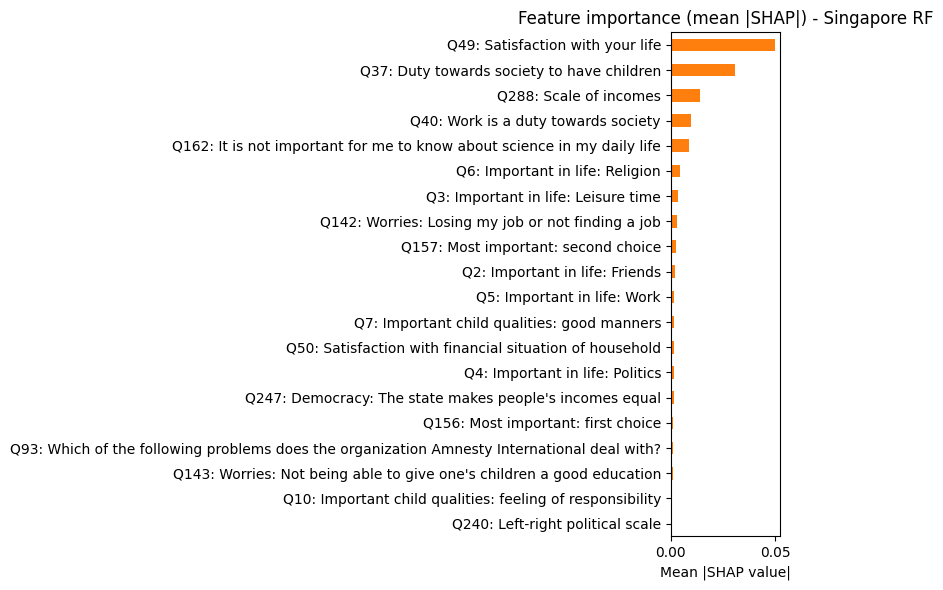

Top 10 features by mean |SHAP|:
Q49: Satisfaction with your life                                           0.049899
Q37: Duty towards society to have children                                 0.030827
Q288: Scale of incomes                                                     0.014077
Q40: Work is a duty towards society                                        0.009773
Q162: It is not important for me to know about science in my daily life    0.008910
Q6: Important in life: Religion                                            0.004614
Q3: Important in life: Leisure time                                        0.003343
Q142: Worries: Losing my job or not finding a job                          0.002892
Q157: Most important: second choice                                        0.002358
Q2: Important in life: Friends                                             0.002273
dtype: float64


In [14]:
# Cell 6 - SHAP: simplified ranked mean(|SHAP|) horizontal bar chart
# This cell preserves DataFrame column names, samples a small background for TreeExplainer,
# and plots mean absolute SHAP per feature as a horizontal bar chart (top-N).
# Ensure prerequisites: `features`, `X_sg`, `y_sg`, and `rf` should exist from earlier cells.

# ensure a preprocessor exists and is fitted (fit on X_sg if needed)
if 'preprocessor' not in globals():
    preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
# try a quick transform to detect if fitted; otherwise fit on X_sg
try:
    _ = preprocessor.transform(X_sg.iloc[:1])
except Exception:
    preprocessor.fit(X_sg.fillna(X_sg.median()))

# build a DataFrame of preprocessed features so column names are preserved
if 'X_sg_proc_df' in globals():
    X_shap_df = X_sg_proc_df.copy()
else:
    X_shap_input = X_sg[features].copy()
    X_shap_input = X_shap_input.fillna(X_shap_input.median())
    X_shap_proc = preprocessor.transform(X_shap_input)
    X_shap_df = pd.DataFrame(X_shap_proc, columns=features, index=X_shap_input.index)

# Ensure the RF model has feature names info; if not, clone & (re)fit on DataFrame slice
from sklearn.base import clone
rf_for_shap = rf
need_refit = False
if not hasattr(rf_for_shap, 'feature_names_in_'):
    need_refit = True
else:
    try:
        if list(rf_for_shap.feature_names_in_) != list(features):
            need_refit = True
    except Exception:
        need_refit = True
if need_refit:
    rf_for_shap = clone(rf)
    rf_for_shap.fit(X_shap_df, y_sg.loc[X_shap_df.index])

# create a small background sample for the explainer (keeps things fast)
bg_n = min(200, len(X_shap_df))
bg = X_shap_df.sample(n=bg_n, random_state=0)

# compute SHAP values using TreeExplainer where possible; fallback to generic Explainer
try:
    expl = shap.TreeExplainer(rf_for_shap, data=bg)
    shap_vals = expl.shap_values(X_shap_df)
except Exception:
    expl = shap.Explainer(rf_for_shap.predict, bg)
    # shap.Explainer returns an object w/ .values for most models
    out = expl(X_shap_df)
    try:
        shap_vals = out.values
    except Exception:
        # final fallback: compute numeric array from object
        shap_vals = np.array(out)

# shap_vals might be a list (multiclass) or ndarray. Convert to absolute and average appropriately
import numpy as np
if isinstance(shap_vals, list):
    # for multiclass, average absolute values across classes
    arr = np.mean([np.abs(s) for s in shap_vals], axis=0)
else:
    arr = np.abs(shap_vals)
mean_abs = np.mean(arr, axis=0)
imp = pd.Series(mean_abs, index=features).sort_values(ascending=True)

# Plot top-N features as horizontal bar chart
topn = 20
imp_top = imp.tail(topn)
plt.figure(figsize=(8, max(4, 0.3 * topn)))
imp_top.plot.barh(color='C1')
plt.xlabel('Mean |SHAP value|')
plt.title('Feature importance (mean |SHAP|) - Singapore RF')
plt.tight_layout()
plt.show()

# Print the top 10 features for quick reference
print('Top 10 features by mean |SHAP|:')
print(imp.sort_values(ascending=False).head(10))


In [11]:
# Cell 7 - replicate modelling on global sample; compare feature importance
# Prepare global dataset same way:
global_df = df_global.dropna(subset=[target_col]).copy()
global_df = global_df[(global_df['age'] >= 20) & (global_df['age'] <= 49)]

# You may need to subset to rows with valid features
X_global = global_df[features].copy()
y_global = global_df[target_col]

# Ensure a preprocessor exists (fit if missing). Use a simple numeric pipeline:
# SimpleImputer (median) + StandardScaler
if 'preprocessor' not in globals():
	preprocessor = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='median')),
		('scaler', StandardScaler())
	])
	# Prefer to fit on already-prepared Singapore data if available, otherwise fit on X_global
	if 'X_sg_proc' in globals():
		preprocessor.fit(X_sg_proc)
	else:
		preprocessor.fit(X_global.fillna(X_global.median()))

# Transform global features (pipeline will impute missing values)
X_global_proc = preprocessor.transform(X_global)

# Train RF on global
rf_global = RandomForestRegressor(n_estimators=200, random_state=42)
rf_global.fit(X_global_proc, y_global)

# Compute permutation importances or SHAP for both and compare top 15
importances_sg = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False).head(15)
importances_global = pd.Series(rf_global.feature_importances_, index=features).sort_values(ascending=False).head(15)
print("SG top features:\n", importances_sg)
print("Global top features:\n", importances_global)


SG top features:
 Q270: Number of people in household                                                                    0.293387
age                                                                                                    0.227852
Q288: Scale of incomes                                                                                 0.033758
Q37: Duty towards society to have children                                                             0.033121
Q49: Satisfaction with your life                                                                       0.030778
Q247: Democracy: The state makes people's incomes equal                                                0.026845
Q35: Problem if women have more income than husband                                                    0.026125
Q162: It is not important for me to know about science in my daily life                                0.024417
Q6: Important in life: Religion                                                       

In [12]:
# Cell 8 - interaction example
global_df['income_scale'] = global_df['Q288: Scale of incomes']  # rename as needed
# create an interaction term example: income_scale * 'Problem if women have more income than husband'
global_df['interaction_example'] = (global_df['Q288: Scale of incomes'].fillna(0) *
                                   global_df['Q35: Problem if women have more income than husband'].fillna(0))
# include interaction in model


In [13]:
# Cell 9 - streamlit prototype sketch (save as app.py)
import streamlit as st
import pickle
# load your trained model & preprocessor
# model = pickle.load(open('rf_sg_model.pkl','rb'))
# preprocessor = pickle.load(open('preprocessor.pkl','rb'))

st.title("Family Planning Insight Tool (Prototype)")
age = st.number_input("Age", min_value=18, max_value=60, value=30)
income_scale = st.selectbox("Income scale", [1,2,3,4,5])
q_duty = st.slider("Duty towards society to have children (low-high)", 0, 10, 5)

if st.button("Get insight"):
    x = pd.DataFrame([{ 'age': age, 'Q288: Scale of incomes': income_scale, 'Q37: Duty towards society to have children': q_duty }])
    Xp = preprocessor.transform(x[features])
    pred_children = model.predict(Xp)[0]
    st.write(f"Modelled expected number of children: {pred_children:.2f}")
    # show SHAP explanation
    shap_vals = explainer(Xp)
    st.pyplot(shap.plots.force(shap_vals))


2025-11-03 23:38:40.765 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 23:38:40.852 
  command:

    streamlit run c:\Users\UserAdmin\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-11-03 23:38:40.853 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 23:38:40.854 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 23:38:40.856 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 23:38:40.856 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 23:38:40.857 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 23